In [1]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""
%matplotlib inline

import arpes.config

arpes.config.DOCS_BUILD = True

Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-10-11_05-46-00.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


# Converting ARPES Data to Momentum-Space

**Note**: We will use Fermi edge corrected data for conversion. The function `load_energy_corrected` below handles this. You can see the document on Fermi edge corrections for more details.


## Converting Volumetric Data

PyARPES provides a consistent interface for converting ARPES data from angle to momentum space. This means that there is only a single function that provides an entrypoint for converting volumetric data: `arpes.utilities.conversion.convert_to_kspace`.

Using the PyARPES data plugins, you can be confident that your data will convert to momentum immediately after you load it, so long as it follows the PyARPES spectral model.

In [2]:
import matplotlib.pyplot as plt
from arpes.fits.fit_models import AffineBroadenedFD, QuadraticModel
from arpes.fits.utilities import broadcast_model
from arpes.io import example_data
from arpes.utilities.conversion import convert_to_kspace


def load_energy_corrected():
    fmap = example_data.map.spectrum
    cut = fmap.sum("theta").sel(eV=slice(-0.2, 0.1), phi=slice(-0.25, 0.3))

    results = broadcast_model(AffineBroadenedFD, cut, "phi")
    edge = QuadraticModel().guess_fit(results.F.p("fd_center")).eval(x=fmap.phi)
    return fmap.G.shift_by(edge, shift_axis="eV", by_axis="phi")


energy_corrected = load_energy_corrected()
energy_corrected.attrs["energy_notation"] = "Binding"

Fitting on pool...:   0%|          | 0/96 [00:00<?, ?it/s]

/Users/arafune/src/arpes/arpes/fits/fit_models/fermi_edge.py:76: RuntimeWarning: overflow encountered in exp
  fermi = 1 / (np.exp(dx / fd_width) + 1)
/Users/arafune/src/arpes/arpes/fits/fit_models/fermi_edge.py:76: RuntimeWarning: divide by zero encountered in divide
  fermi = 1 / (np.exp(dx / fd_width) + 1)
/Users/arafune/src/arpes/arpes/fits/fit_models/fermi_edge.py:76: RuntimeWarning: divide by zero encountered in divide
  fermi = 1 / (np.exp(dx / fd_width) + 1)


## A first conversion

Now that we have our data loaded, let's convert a Fermi surface to momentum.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


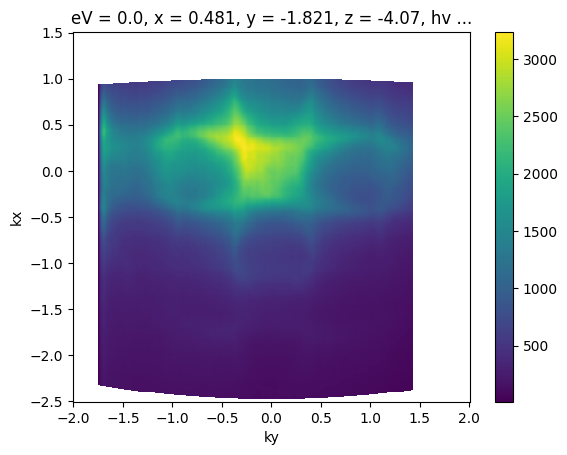

In [3]:
import numpy as np

convert_to_kspace(
    energy_corrected.S.fermi_surface,  # just convert the Fermi surface
    kx=np.linspace(-2.5, 1.5, 400),  # along -2.5 <= kx < 1.5 (inv ang.)
    #  with 400 steps
    ky=np.linspace(-2, 2, 400),  # as above, with -2 <= ky < 2
).S.plot()

## Coordinate Offsets

PyARPES knows how to convert data from angle-to-momentum because data in PyARPES specifies both the experimental geometry and the angular offsets corresponding to normal emission.

The geometry is specified by the data loading code which you typically do not change, but the angular offsets may change depending on how samples are mounted, DAQ software calibration, or any number of other reasons.


The data sample above *already* has offsets set, which is why the $\Gamma$ point correctly shows up at zero parallel momentum. We can also set offsets:

{'alpha': 0.0,
 'beta': 0.0,
 'chi': -1.4851355,
 'phi': 0.05671,
 'psi': 0.0,
 'theta': -0.01392}


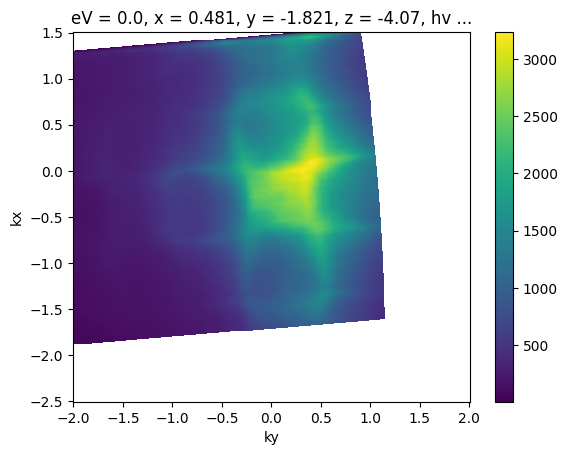

In [4]:
# Let's look at what the assigned values were, for some reference
import pprint  # pretty print

pprint.pprint(energy_corrected.S.offsets)

example_fs = energy_corrected.S.fermi_surface.copy(deep=True)
example_fs.S.apply_offsets(
    {
        "phi": 0.0,  # controls the offset along the analyzer center axis
        "theta": 0.0,
        "chi": 0.0,  # sample rotation, controls kx-ky plane orientation
        "alpha": 0.0,
        "psi": 0.0,
    }
)
convert_to_kspace(
    example_fs,
    kx=np.linspace(-2.5, 1.5, 400),
    ky=np.linspace(-2, 2, 400),
).S.plot()

## Best Practices for Offsets

### Maintaining Offsets

Once you've found offsets, they tend to be the same for all scans on a given cleave or sample. It's a good idea to keep your angular offsets in a local module or otherwise written down. I tend to put them into a local module next to notebooks so that I can run code like:

```python
from local.constants import angle_offsets

my_scan.S.apply_offsets(angle_offsets["sample_1"])
```

You'll likely have different ideas about what you find convenient.

### Finding Offsets

There are a lot of different ways to do this. You can plot like above until you are happy. Often, you might want to use a Brillouin zone overlay to help you align symmetry points.

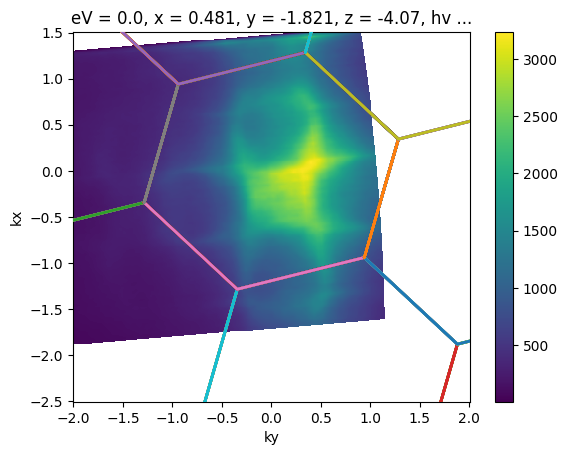

In [5]:
from arpes.plotting.bz import overplot_standard

convert_to_kspace(
    example_fs,
    kx=np.linspace(-2.5, 1.5, 400),
    ky=np.linspace(-2, 2, 400),
).S.plot()

# plot a graphene BZ over the data... obviously silly here
# to demonstrate parameters we'll rotate 30 degrees and plot several higher BZs.
bz_plotter = overplot_standard("ws2", repeat=([-2, 2], [-2, 2]), rotate=np.pi / 12)
ax = bz_plotter(plt.gca())

You can also use prior knowledge of the sample setup to find good offsets, adjust from other scans, or use an interactive conversion tool:

In [6]:
from arpes.plotting.qt_ktool import ktool

ktool(example_fs, zone="graphene")

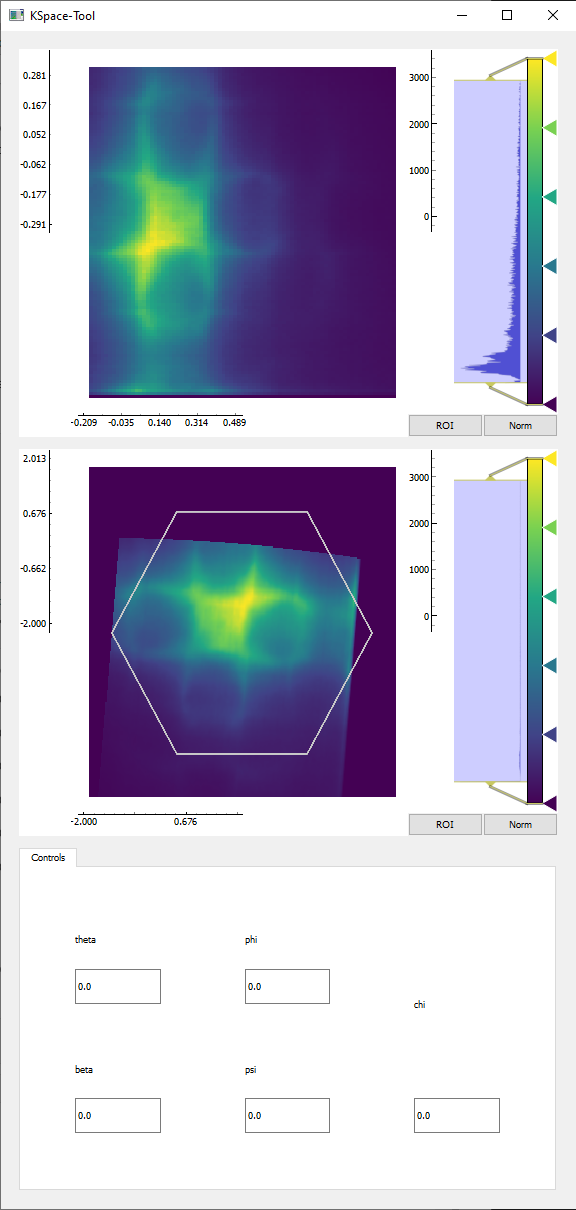

## Converting the entire volume

In [7]:
import numpy as np

kcube = convert_to_kspace(
    energy_corrected,
    kx=np.linspace(-2.5, 1.5, 400),
    ky=np.linspace(-2, 2, 400),
)

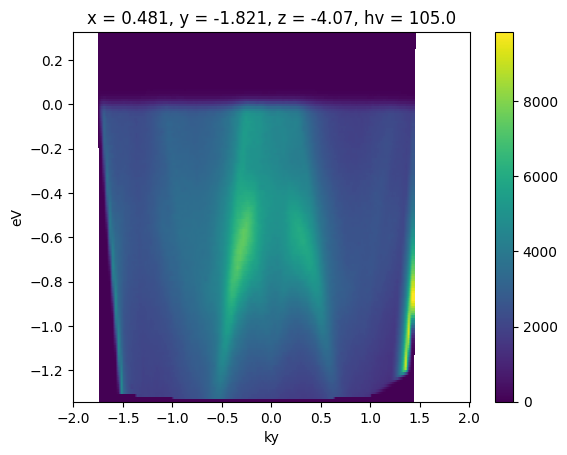

In [8]:
kcube.sel(kx=slice(-0.02, 0.02)).mean("kx").S.plot()

## Determining the Momentum Coordinates of Particular Points

Frequently, you might need to perform some analysis in the vicinity of a particular point whose coordinates you know in angle-space, but your results need to be presented in momentum-space.

Unless you want to perform your analysis in angle-space and convert results to momentum, you need to know how to project points and coordinates forward from angle to momentum.

The volumetric transform is based off an interpolated *inverse* transform: the momentum coordinates are converted to angle for the interplation step, which may be contrary to your expectations if you've not worked with interpolations before. In PyARPES and most ARPES software, this inverse transform is small angle approximated in some circumstances. For this reason, PyARPES provides both an exact angle-to-momentum converter suitable for coordinates, and an exact inverse to the small angle approximated volumetric transform.

The latter is typically what you want when you are doing volumetric transforms, because it tells you exactly where a feature of interest will end up in momentum after you invoke `convert_to_kspace`.

Let's see how it works.

First, let's pick any point in angle space which we will use to represent our feature of interest:

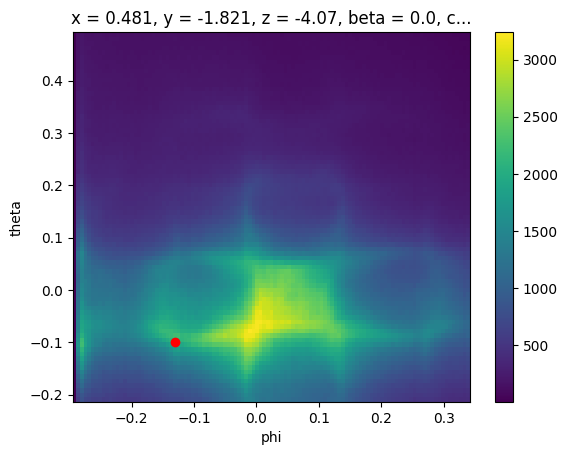

In [9]:
energy_corrected.S.fermi_surface.S.plot()
plt.gca().scatter([-0.13], [-0.1], color="red")

# we will determine where this point goes
test_point = {
    "phi": -0.13,
    "theta": -0.1,
    "eV": 0,
}

In [10]:
from arpes.utilities.conversion.forward import convert_coordinate_forward

k_test_point = convert_coordinate_forward(energy_corrected, test_point)

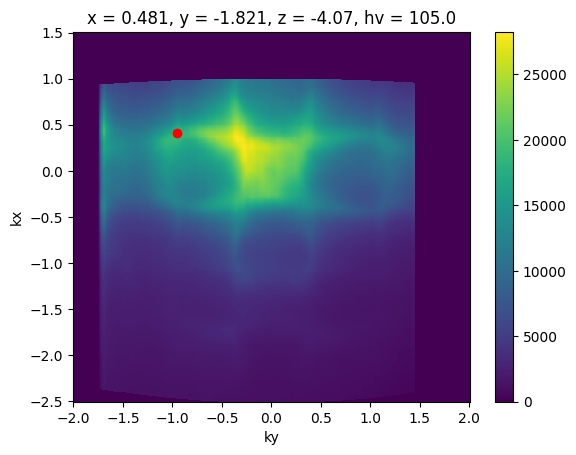

In [11]:
kcube.sel(eV=slice(-0.05, 0.05)).sum("eV").S.plot()
plt.gca().scatter([k_test_point["ky"]], [k_test_point["kx"]], color="red")

Excellent, this enables all kinds of analysis which we frequently want to perform.

## Exactracting a Momentum Cut Passing Thorugh Known Angular Coordinates

For instance, we can determine a momentum cut passing through our point of interest.

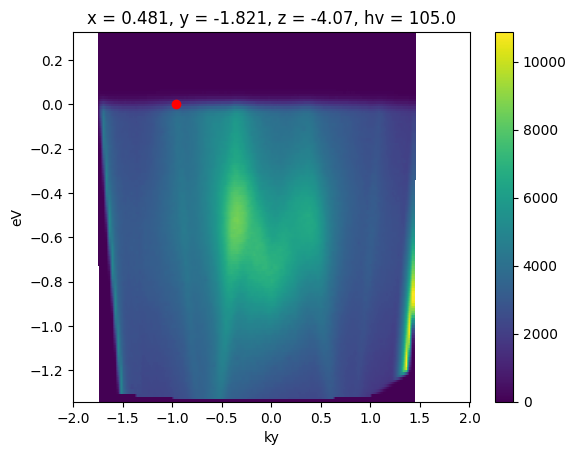

In [12]:
ky_slice = (
    convert_to_kspace(
        energy_corrected,
        kx=np.linspace(k_test_point["kx"] - 0.02, k_test_point["kx"] + 0.02, 20),
        ky=np.linspace(-2, 2, 800),
    )
    .mean("kx")
    .S.plot()
)

plt.gca().scatter([k_test_point["ky"]], [0.0], color="red")

This is common enough that there is a utility for it in PyARPES: `convert_through_angular_point`.

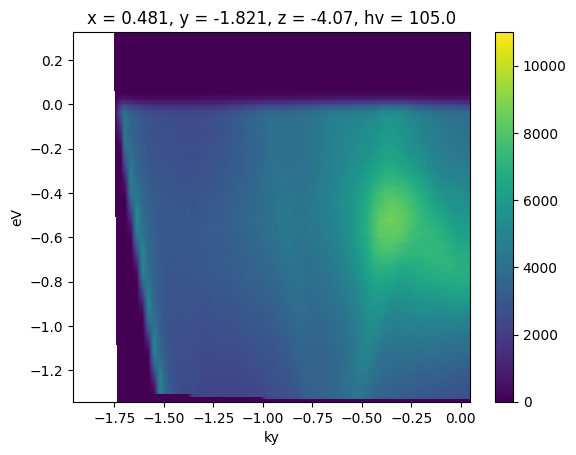

In [13]:
from arpes.utilities.conversion.forward import convert_through_angular_point

convert_through_angular_point(
    energy_corrected,
    test_point,
    {"ky": np.linspace(-1, 1, 400)},  # give the cut which has +/- 1 inv ang
    # in `kx` around our point of interest
    {"kx": np.linspace(-0.02, 0.02, 10)},  # take 20 milli inv ang. perpendicular
).S.plot(
    vmax=11000
)  # set vmax for better comparison to above

What if we wanted to take a rotated cut through this point, rather than one aligned to the `kx` and `ky` axes above?

The simplest thing to do is to apply a sample rotation offset before performing the slice, so that the momentum axes are now aligned to the desirable directions.

We can use the rotation offset context manager for this.

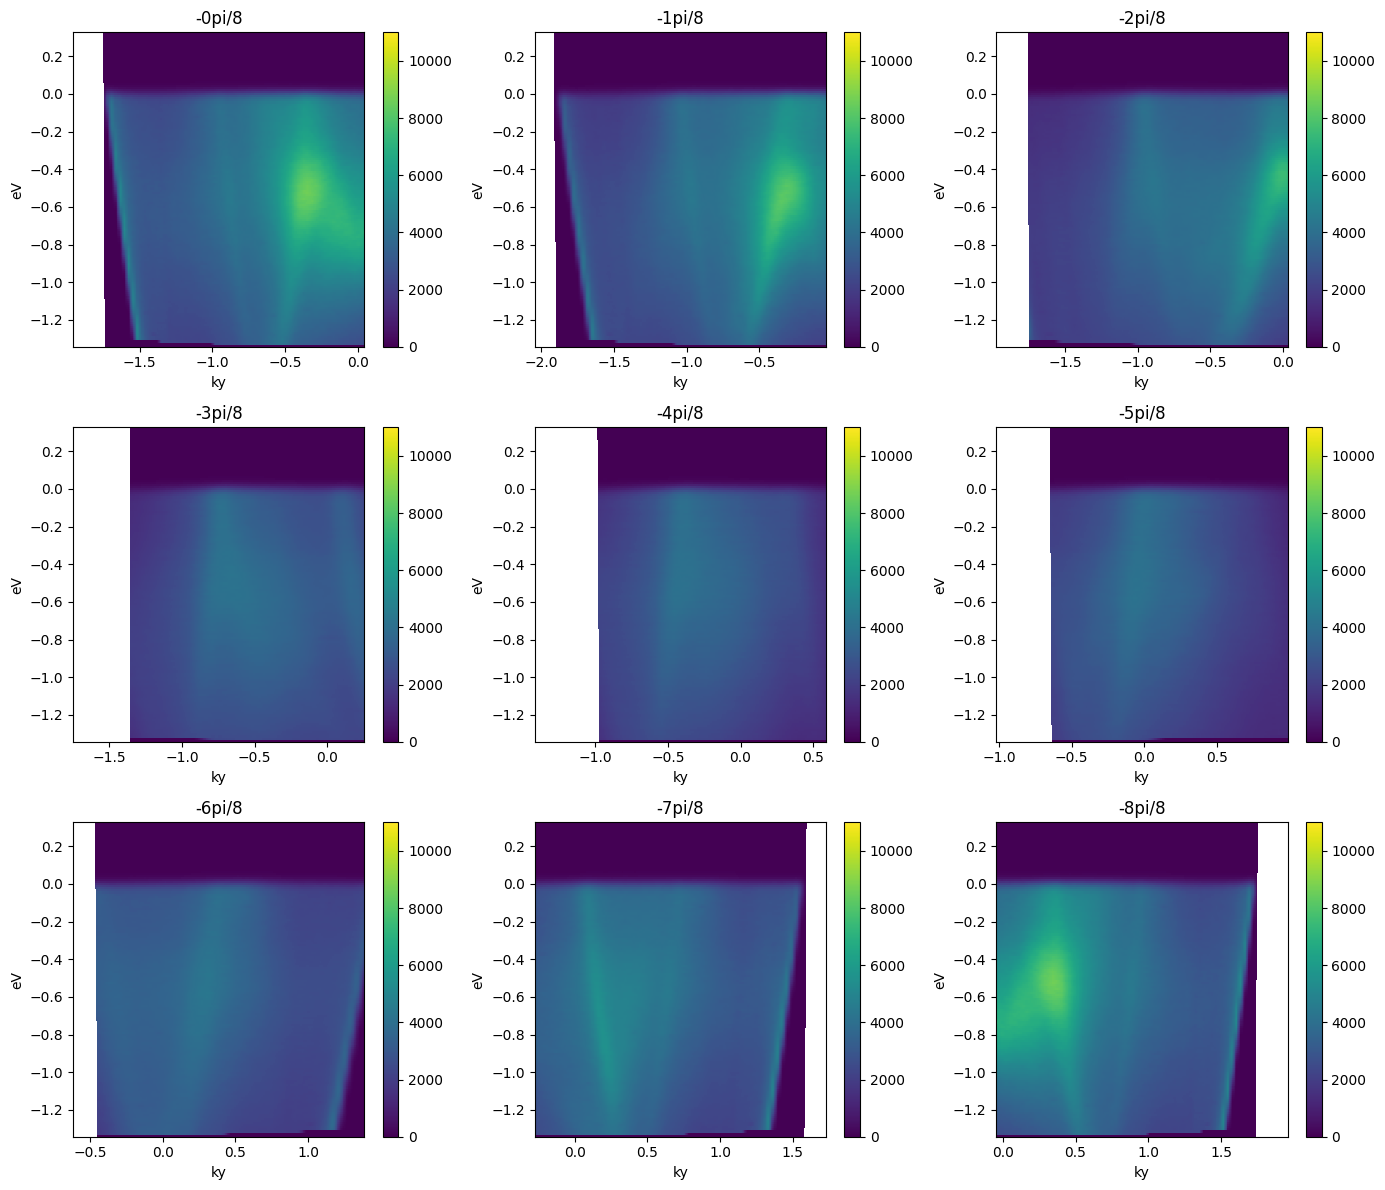

In [14]:
from arpes.config import use_tex

use_tex(rc_text_should_use=False)  # just to be safe, in case you don't have LaTeX installed

fig, ax = plt.subplots(3, 3, figsize=(14, 12))

for inc in range(9):
    with energy_corrected.S.with_rotation_offset(-inc * np.pi / 8):
        convert_through_angular_point(
            energy_corrected,
            test_point,
            {"ky": np.linspace(-1, 1, 400)},
            {"kx": np.linspace(-0.02, 0.02, 10)},
        ).S.plot(vmax=11000, ax=ax.ravel()[inc])
        ax.ravel()[inc].set_title(f"-{inc}pi/8")

plt.tight_layout()


Note that the first and last plots are merely reflections of one another, because a rotation by pi is equivalent to inverting the `ky` axis of the cut.

## Getting an ARPES Cut Passing Through Two Angular Points

Suppose we know the angular coordinates of two high symmetry points in our dataset and we wanted to get a high symmetry cut passing through both. We have just seen how to do this with one point.

PyARPES has `convert_through_angular_pair` for this purpose.

This type of conversion is very useful for presenting high symmetry directions in a band structure which came from a higher dimensional dataset like a map.

Let's pick two points so we can be concrete.

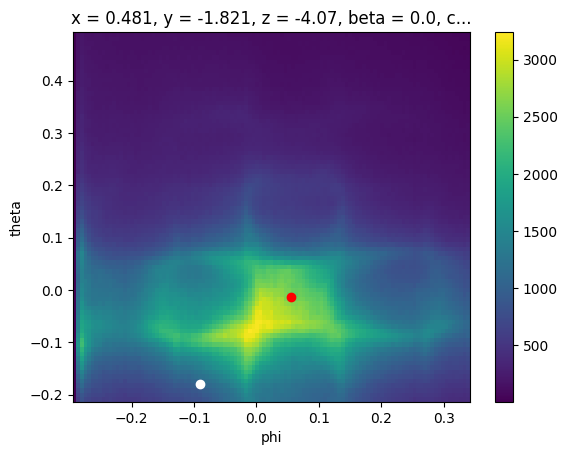

In [15]:
energy_corrected.S.fermi_surface.S.plot()
plt.gca().scatter([0.055], [-0.013], color="red")
plt.gca().scatter([-0.09], [-0.18], color="white")


# we will get the cut through these two points
p1 = {
    "phi": 0.055,
    "theta": -0.013,
    "eV": 0,
}
p2 = {
    "phi": -0.09,
    "theta": -0.18,
    "eV": 0,
}

In [16]:
from arpes.analysis.moire import angle_between_vectors

kp1 = convert_coordinate_forward(energy_corrected, p1)
kp2 = convert_coordinate_forward(energy_corrected, p2)


def to_vec(p):
    return np.array([p["kx"], p["ky"]])


print(kp1)
print(kp2)
print(to_vec(kp1))
print(to_vec(kp2))
delta = to_vec(kp2) - to_vec(kp1)
ang = np.arctan2(delta[1], delta[0])
print(ang)

with energy_corrected.S.with_rotation_offset(-ang):
    kp1 = convert_coordinate_forward(energy_corrected, p1)
    kp2 = convert_coordinate_forward(energy_corrected, p2)

    print(kp1, kp2)

    delta = to_vec(kp2) - to_vec(kp1)
    print(np.arctan2(delta[1], delta[0]))

{'kx': -0.027115300158778416, 'ky': -0.022266815310293564}
{'kx': 0.9003614742745181, 'ky': -0.7552690787473395}
[-0.0271153  -0.02226682]
[ 0.90036147 -0.75526908]
-0.6688097857188012
{'kx': -0.007721360764839022, 'ky': -0.03447721360764837} {'kx': 1.174384649167258, 'ky': -0.03447721360764837}
0.0


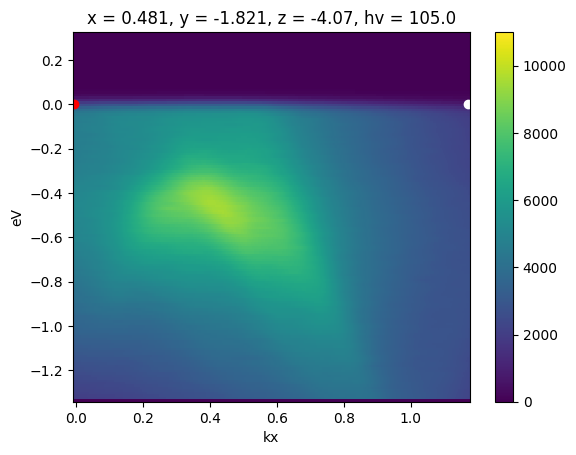

In [17]:
from arpes.utilities.conversion.forward import convert_through_angular_pair

convert_through_angular_pair(
    energy_corrected,
    p1,
    p2,
    {"kx": np.linspace(-0, 0, 400)},  # interpolate from p1 to p2 only
    {"ky": np.linspace(-0.02, 0.02, 10)},  # take 20 milli inv ang. perpendicular
).S.plot(vmax=11000)

# plotted only for legibility
plt.gca().scatter([-0.007], [0.0], color="red")
plt.gca().scatter([1.17], [0.0], color="white")

This interpolate only between `p1` and `p2`. To interpolate further in either direction, wejust need to set the margin wider. Let's interpolate one inverse angstrom past `p1` away from `p2`.

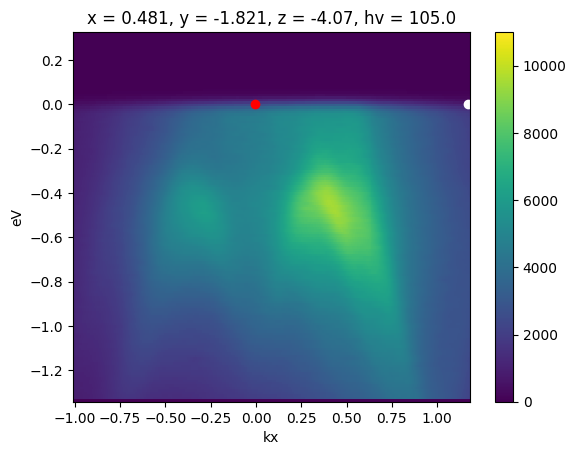

In [18]:
from arpes.utilities.conversion.forward import convert_through_angular_pair

convert_through_angular_pair(
    energy_corrected,
    p1,
    p2,
    {"kx": np.linspace(-1, 0, 400)},  # interpolate 1 inv ang. further left
    {"ky": np.linspace(-0.02, 0.02, 10)},  # take 20 milli inv ang. perpendicular
).S.plot(vmax=11000)

# plotted only for legibility
plt.gca().scatter([-0.007], [0.0], color="red")
plt.gca().scatter([1.17], [0.0], color="white")

## API for Other Types of Conversions

There's only one API in PyARPES for coordinate conversion. The entire geometry is specified on the data by convention. So you typically do not need to do any work to choose the appropriate conversion routine.

### Extra dimensions

You can convert datasets with extra dimensions, which just act as passthroughs: each slice is converted as you would expect.

We can see this on our temperature dependence data.

In [19]:
from arpes.io import example_data
from arpes.utilities.conversion import convert_to_kspace

temp_dep = example_data.temperature_dependence.spectrum

# We will Let PyARPES infer an appropriate kp range
ktemp_dep = convert_to_kspace(temp_dep)
ktemp_dep.dims

('eV', 'kp', 'temperature')

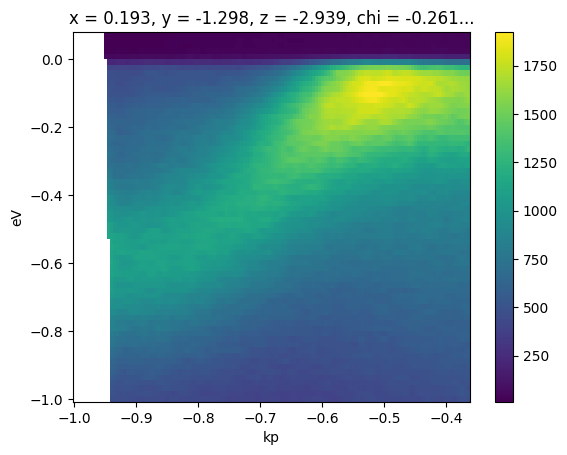

In [20]:
ktemp_dep.isel(temperature=0).S.plot()

### Photon Energy Scans

This also operates the same way. The only caveat is that you may need to assign the inner potential (on `.attrs`) in order to get good periodicity in `kz`.

Text(0.5, 1.0, '')

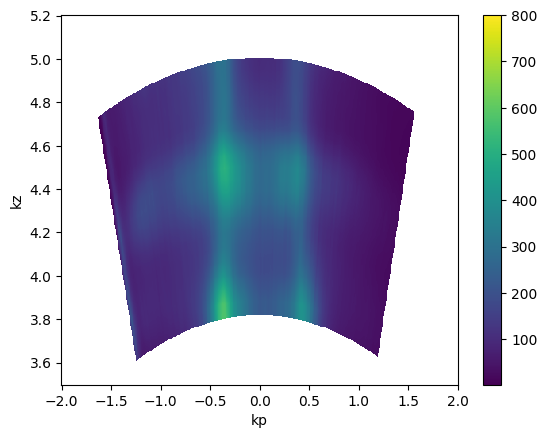

In [21]:
import numpy as np
from arpes.io import example_data
from arpes.utilities.conversion import convert_to_kspace

hv_scan = example_data.photon_energy.spectrum

kz_data = convert_to_kspace(
    hv_scan.S.fermi_surface,
    kp=np.linspace(-2, 2, 500),
    kz=np.linspace(3.5, 5.2, 400),
)

kz_data.T.S.plot(vmax=800)
plt.gca().set_title("")

### Inner potential

We can also set the inner potential to a different value to see its effect.

Text(0.5, 1.0, 'Inner potential: 100 eV')

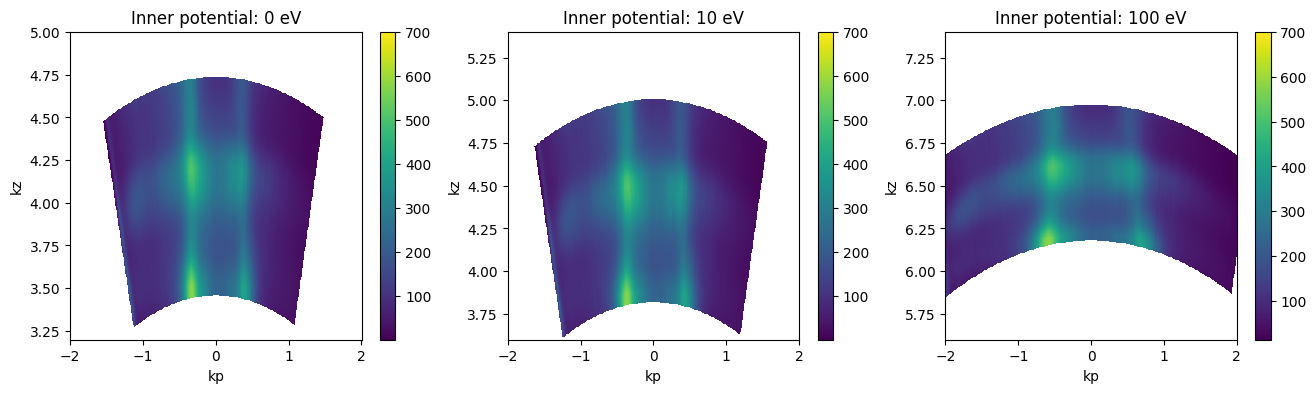

In [22]:
hv_fs = example_data.photon_energy.spectrum.S.fermi_surface

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

hv_fs.attrs["inner_potential"] = 0.0
kz_data = convert_to_kspace(
    hv_fs,
    kp=np.linspace(-2, 2, 500),
    kz=np.linspace(3.2, 5, 400),
).T.S.plot(vmax=700, ax=axes[0])

hv_fs.attrs["inner_potential"] = 10.0
kz_data = convert_to_kspace(
    hv_fs,
    kp=np.linspace(-2, 2, 500),
    kz=np.linspace(3.2 + 0.4, 5 + 0.4, 400),
).T.S.plot(vmax=700, ax=axes[1])

hv_fs.attrs["inner_potential"] = 100.0
kz_data = convert_to_kspace(
    hv_fs,
    kp=np.linspace(-2, 2, 500),
    kz=np.linspace(3.2 + 2.4, 5 + 2.4, 400),
).T.S.plot(vmax=700, ax=axes[2])

axes[0].set_title("Inner potential: 0 eV")
axes[1].set_title("Inner potential: 10 eV")
axes[2].set_title("Inner potential: 100 eV")

From the above, we can see that an inner potential for this test sample of above 10eV is probably too large. 10eV is possibly too large as well, but does not look very distorted.

Absolute $k_z$ values depend on the value of the inner potential $V_0$, so it's a good idea to consider also the periodicity in `kz` when setting the inner potential.

## Exercises

1. If you look at the PyARPES spectral model, some angles may appear to have the same effect. Under what conditions does increasing the `phi_offset` and decreasing the `theta_offset` result in the same momentum space data?
2. Play around with finding good coordinate offsets and applying them.
3. What is the meaning of the original `chi_offset` on `example_data.map`. What assumptions does this default behavior make?
4. Use each of `convert_through_angular_point` and `convert_through_angular_pair` to make high symmetry selections through the `kx-ky` scan above.